In [220]:
import pandas as pd
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, save_model, load_model
from pycaret.regression import *
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim

In [207]:
# 가격 데이터 불러오기
df = pd.read_csv("../../data/prep/item_price_filled_pivot.csv")
df['priceDate'] = pd.to_datetime(df['priceDate'])
# df = df[df['market'].isin(['노량진 1층','노량진 2층'])] #노량진 시장으로 한정정
df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()
# df = df[df['item'] == "대게_avgPrice"]

#트렌드 지표
bigcrab = pd.read_csv("../../data/processed/그룹화_nst_대게_trend_2025-01-17.csv")
bigcrab['priceDate'] = pd.to_datetime(bigcrab['date'])# = bigcrab.drop(["date","name"], axis=1)

#경제지표
economy = pd.read_csv("../../data/prep/economy_filled.csv")
economy['priceDate'] = pd.to_datetime(economy['날짜'])
# economy['USD/KRW'] = economy['USD/KRW'].shift(-2)
# economy['KOSPI'] = economy['KOSPI'].shift(-4)
# economy['Gold'] = economy['Gold'].shift(-150)
# economy['WTI'] = economy['WTI'].shift(-101)

#환경지표
forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['priceDate'] = pd.to_datetime(forecast_df['일시'])
# 가거도 제거
forecast_df = forecast_df[~forecast_df['지점'].isin([22297, 22193])]
buoy_filtered = forecast_df[forecast_df['지점'] == 22107].drop(columns=['일시','풍속','GUST풍속','습도','기온','최대파고','유의파고','평균파고','파주기','지점'])

merged_df = pd.merge(df, bigcrab, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, economy, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, buoy_filtered, on='priceDate')
merged_df = merged_df.drop(["name","date","날짜"], axis=1)
# merged_df['현지기압'] = merged_df['현지기압'].shift(-83)
# merged_df['수온'] = merged_df['수온'].shift(-143)
# merged_df['40대'] = merged_df['40대'].shift(-1)
# merged_df['20대'] = merged_df['20대'].shift(-1)
# merged_df['50대'] = merged_df['50대'].shift(-1)
# merged_df['30대'] = merged_df['30대'].shift(-1)
# merged_df['60대 이상'] = merged_df['60대 이상'].shift(-1)
# merged_df = merged_df.drop(index=merged_df.index[-143:])
xgap = merged_df.drop(columns=['대게_avgPrice','priceDate'])

ygap = merged_df['대게_avgPrice']
xgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   20대      2452 non-null   float64
 1   30대      2452 non-null   float64
 2   40대      2452 non-null   float64
 3   50대      2452 non-null   float64
 4   60대 이상   2452 non-null   float64
 5   KOSPI    2452 non-null   float64
 6   USD/KRW  2452 non-null   float64
 7   WTI      2452 non-null   float64
 8   VIX      2452 non-null   float64
 9   Gold     2452 non-null   float64
 10  Silver   2452 non-null   float64
 11  MOVE     2452 non-null   float64
 12  현지기압     2379 non-null   float64
 13  수온       2392 non-null   float64
dtypes: float64(14)
memory usage: 268.3 KB


In [208]:
# 데이터 스케일링 (가격과 경제 데이터)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(xgap)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(ygap.values.reshape(-1, 1))

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 모델 생성 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train.ravel())  # ravel()로 1D로 변환

# 예측 수행
y_pred_scaled = model.predict(X_test)

# 예측 결과를 원래 스케일로 변환
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test)

In [210]:
# 성능 평가
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 1550.96
RMSE: 2368.67


In [221]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=100, batch_first=True)
        self.fc = nn.Linear(100, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 데이터 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# 모델 학습
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

MAE (평균 절대 오차): 2940415081.45
RMSE (평균 제곱근 오차): 2974217309.73
R² Score (결정계수): -88326494652.6055


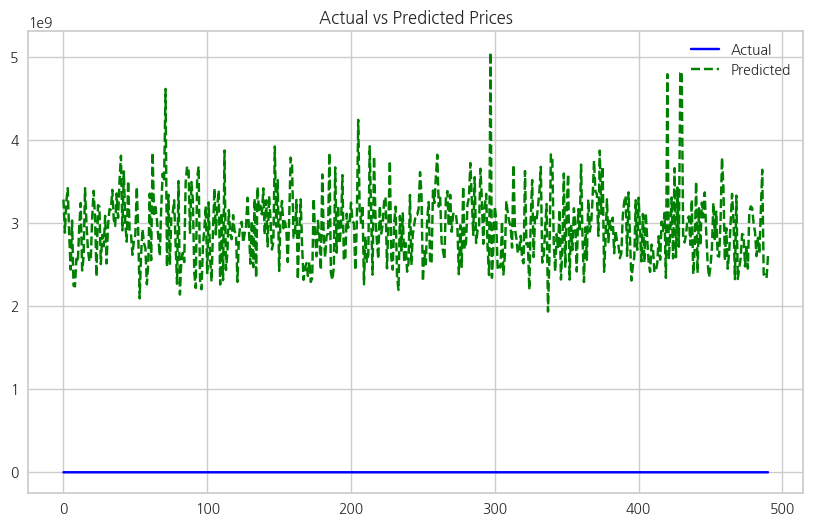

In [222]:
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# 평가 지표 계산
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

# 결과 출력
print(f'MAE (평균 절대 오차): {mae:.2f}')
print(f'RMSE (평균 제곱근 오차): {rmse:.2f}')
print(f'R² Score (결정계수): {r2:.4f}')

# 실제 vs 예측 비교 그래프
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(y_pred_original, label='Predicted', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

In [213]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)  
])

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test))

# 예측 및 역변환
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0630 - val_loss: 0.0245
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275 - val_loss: 0.0241
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - val_loss: 0.0239
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - val_loss: 0.0258
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0239 - val_loss: 0.0235
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0250 - val_loss: 0.0236
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0243 - val_loss: 0.0230
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0241 - val_loss: 0.0235
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0224 - val_loss: 0.0229
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0226 - val_loss: 0.0209
Epoch 12/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

MAE (평균 절대 오차): 4819.52
RMSE (평균 제곱근 오차): 6012.27
R² Score (결정계수): 0.6391


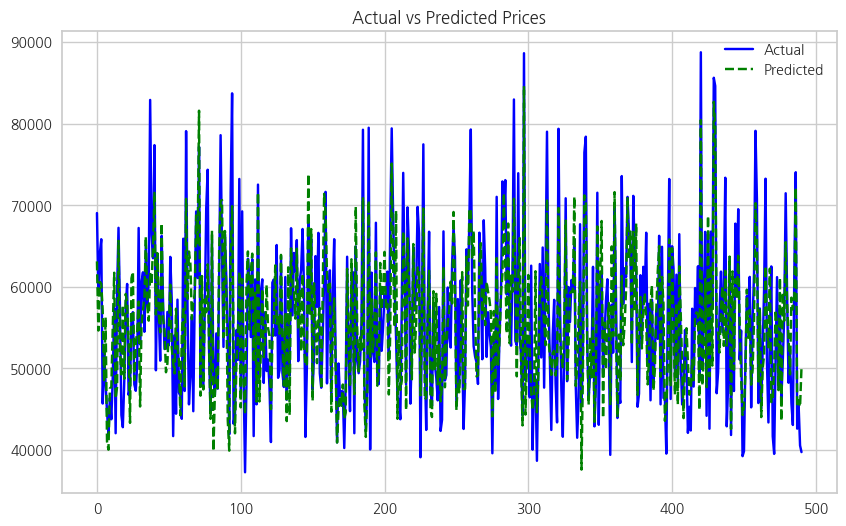

In [215]:
# 원래 스케일로 변환한 실제 값
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 평가 지표 계산
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f'MAE (평균 절대 오차): {mae:.2f}')
print(f'RMSE (평균 제곱근 오차): {rmse:.2f}')
print(f'R² Score (결정계수): {r2:.4f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

In [120]:
# 예측 수행
y_pred = model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 0.16
RMSE: 0.21


In [56]:
# 가격 데이터 불러오기
df = pd.read_csv("../../data/prep/item_price_filled_pivot.csv")
df['priceDate'] = pd.to_datetime(df['priceDate'])
# df = df[df['market'].isin(['노량진 1층','노량진 2층'])] #노량진 시장으로 한정정
df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()
# df = df[df['item'] == "대게_avgPrice"]

#트렌드 지표
bigcrab = pd.read_csv("../../data/processed/그룹화_nst_대게_trend_2025-01-17.csv")
bigcrab['priceDate'] = pd.to_datetime(bigcrab['date'])# = bigcrab.drop(["date","name"], axis=1)

#경제지표
economy = pd.read_csv("../../data/prep/economy_filled.csv")
economy['priceDate'] = pd.to_datetime(economy['날짜'])


#환경지표
forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['priceDate'] = pd.to_datetime(forecast_df['일시'])
# 가거도 제거
forecast_df = forecast_df[~forecast_df['지점'].isin([22297, 22193])]
buoy_filtered = forecast_df[forecast_df['지점'] == 22107].drop(columns=['일시','풍속','GUST풍속','습도','기온','최대파고','유의파고','평균파고','파주기','지점'])

merged_df = pd.merge(df, bigcrab, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, economy, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, buoy_filtered, on='priceDate')
merged_df = merged_df.drop(["name","date","날짜"], axis=1)

merged_df.tail()

,priceDate,대게_avgPrice,20대,30대,40대,50대,60대 이상,KOSPI,USD/KRW,WTI,VIX,Gold,Silver,MOVE,현지기압,수온
2447,2024-12-27,88787.777778,5.142469,7.480666,7.987442,10.752374,4.682081,2404.77002,1466.989990,70.599998,15.95,2617.199951,29.655001,94.800003,1031.333333,17.104167
2448,2024-12-28,89043.333333,4.730225,7.144211,7.166002,9.536471,3.751035,2404.77002,1466.989990,70.599998,15.95,2617.199951,29.655001,94.800003,1029.554167,17.104167
2449,2024-12-29,89005.555556,5.317076,8.215924,7.635628,9.744464,3.763841,2404.77002,1466.989990,70.599998,15.95,2617.199951,29.655001,94.800003,1031.179167,17.029167
2450,2024-12-30,88991.111111,5.623322,9.483198,8.787682,11.501476,5.716786,2399.48999,1472.800049,70.989998,17.40,2606.100098,29.106001,99.080002,1026.454167,17.100000
2451,2024-12-31,89641.111111,5.278148,7.360143,6.998404,7.347583,4.840044,2399.48999,1472.800049,70.989998,17.40,2606.100098,29.106001,99.080002,1024.983333,17.058333


In [57]:
# 예측할 대상과 특징 선택
features = ['20대', '30대','40대','50대','60대 이상', 'KOSPI', 'USD/KRW', 'WTI', 'VIX', 'Gold', 'Silver', 'MOVE', '현지기압','수온']
target = '대게_avgPrice'

In [58]:
X=merged_df[features]
y=merged_df[target]
tscv = TimeSeriesSplit(n_splits=5)

In [59]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 412, Test: 408
Train: 820, Test: 408
Train: 1228, Test: 408
Train: 1636, Test: 408
Train: 2044, Test: 408


In [60]:
# 모델 초기화
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 훈련 및 평가
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae:.2f}")

MAE: 5122.74
MAE: 6574.68
MAE: 9153.45
MAE: 8757.36
MAE: 9879.79


In [61]:
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid, 
                           cv=tscv,
                           scoring='neg_mean_absolute_error')

grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 20, 'n_estimators': 50}


In [52]:
best_params = grid_search.best_params_  # 최적 하이퍼파라미터 추출
best_params

{'max_depth': 20, 'n_estimators': 50}

In [204]:
# 최적의 파라미터를 반영한 모델 재훈련
best_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], 
                                  max_depth=best_params['max_depth'], 
                                  random_state=42)

# 모델 훈련
best_model.fit(X_train, y_train)

# 예측 수행
y_pred = best_model.predict(X_test)

# 평가 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R² Score: {r2:.2f}")

RMSE: 0.05, R² Score: 0.94


# 이하 최고 모델 저장

In [9]:
# 가격 데이터 불러오기
df = pd.read_csv("../../data/prep/item_price_filled_pivot.csv")
df['priceDate'] = pd.to_datetime(df['priceDate'])
# df = df[df['market'].isin(['노량진 1층','노량진 2층'])] #노량진 시장으로 한정정
df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()
# df = df[df['item'] == "대게_avgPrice"]

#트렌드 지표
bigcrab = pd.read_csv("../../data/processed/그룹화_nst_대게_trend_2025-01-17.csv")
bigcrab['priceDate'] = pd.to_datetime(bigcrab['date'])# = bigcrab.drop(["date","name"], axis=1)

#경제지표
economy = pd.read_csv("../../data/prep/economy_filled.csv")
economy['priceDate'] = pd.to_datetime(economy['날짜'])
economy['USD/KRW'] = economy['USD/KRW'].shift(-2)
economy['KOSPI'] = economy['KOSPI'].shift(-4)
economy['Gold'] = economy['Gold'].shift(-150)
economy['WTI'] = economy['WTI'].shift(-101)

#환경지표
forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['priceDate'] = pd.to_datetime(forecast_df['일시'])
# 가거도 제거
forecast_df = forecast_df[~forecast_df['지점'].isin([22297, 22193])]
buoy_filtered = forecast_df[forecast_df['지점'] == 22107].drop(columns=['일시','풍속','GUST풍속','습도','기온','최대파고','유의파고','평균파고','파주기','지점'])

merged_df = pd.merge(df, bigcrab, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, economy, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, buoy_filtered, on='priceDate')
merged_df = merged_df.drop(["name","date","날짜"], axis=1)
merged_df['현지기압'] = merged_df['현지기압'].shift(-83)
# merged_df['수온'] = merged_df['수온'].shift(-143)
# merged_df['40대'] = merged_df['40대'].shift(-1)
# merged_df['20대'] = merged_df['20대'].shift(-1)
# merged_df['50대'] = merged_df['50대'].shift(-1)
# merged_df['30대'] = merged_df['30대'].shift(-1)
# merged_df['60대 이상'] = merged_df['60대 이상'].shift(-1)
merged_df = merged_df.drop(index=merged_df.index[-143:])
merged_df.head()

,priceDate,대게_avgPrice,20대,30대,40대,50대,60대 이상,KOSPI,USD/KRW,WTI,VIX,Gold,Silver,MOVE,현지기압,수온
0,2018-01-03,64685.714286,8.875036,17.436212,13.576893,9.880097,6.236522,2497.520020,1061.079956,67.389999,9.15,1294.800049,17.184999,47.599998,1020.270833,16.550000
1,2018-01-04,64392.857143,8.862564,17.328738,16.207602,13.251323,5.112482,2513.280029,1061.079956,67.389999,9.22,1294.800049,17.188999,47.380001,1018.645833,16.420833
2,2018-01-05,64535.714286,8.579787,17.294285,13.299009,12.524463,5.129686,2510.229980,1061.079956,66.220001,9.22,1293.099976,17.205000,46.070000,1019.845833,16.283333
3,2018-01-06,64618.571429,8.189937,13.286743,13.850701,9.705784,6.628747,2499.750000,1060.500000,66.519997,9.22,1297.500000,17.205000,46.070000,1022.195833,16.162500
4,2018-01-07,64618.571429,9.359353,13.742238,12.664761,11.098586,3.775999,2487.909912,1067.689941,68.470001,9.22,1297.500000,17.205000,46.070000,1020.762500,16.087500


In [10]:
# 예측할 대상과 특징 선택
features = ['20대', '30대','40대','50대','60대 이상', 'KOSPI', 'USD/KRW	', 'WTI', 'VIX', 'Gold', 'Silver', 'MOVE', '현지기압','수온']
target = '대게_avgPrice'

In [11]:
# AutoML 설정
regression_setup = setup(merged_df, target=target, session_id=42, normalize=True)

,Description,Value
0,Session id,42
1,Target,대게_avgPrice
2,Target type,Regression
3,Original data shape,"(2309, 16)"
4,Transformed data shape,"(2309, 18)"
5,Transformed train set shape,"(1616, 18)"
6,Transformed test set shape,"(693, 18)"
7,Numeric features,14
8,Date features,1
9,Rows with missing values,5.8%


In [12]:
# 최적 모델 찾기
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,781.0004,1244482.2448,1110.9705,0.9875,0.0201,0.0142,0.0640
catboost,CatBoost Regressor,1150.2779,2418867.7394,1550.0329,0.9755,0.0280,0.0209,0.6730
lightgbm,Light Gradient Boosting Machine,1302.3263,3582363.8594,1885.8387,0.9640,0.0338,0.0236,0.1440
xgboost,Extreme Gradient Boosting,1287.3578,3921085.0000,1953.7255,0.9609,0.0347,0.0233,0.0900
rf,Random Forest Regressor,1312.1971,3945630.4133,1971.7902,0.9608,0.0355,0.0239,0.1340
knn,K Neighbors Regressor,1248.3608,5155947.0250,2222.2271,0.9485,0.0393,0.0225,0.0100
gbr,Gradient Boosting Regressor,2068.0018,7349754.2210,2706.1650,0.9261,0.0488,0.0376,0.0860
dt,Decision Tree Regressor,1588.0529,9742074.5315,3049.2857,0.9042,0.0547,0.0290,0.0080
ada,AdaBoost Regressor,3579.1711,18108035.4164,4251.7755,0.8173,0.0782,0.0662,0.0350
ridge,Ridge Regression,6304.4433,61374379.6002,7808.9574,0.3855,0.1557,0.1163,0.0060


In [13]:
# 사용 예시
target_column = '대게_avgPrice'
feature_columns = ['KOSPI', 'USD/KRW', 'WTI', 'VIX', 'Gold', 'Silver']

# 최적의 지연 기간 찾기
optimal_lags = find_optimal_lag(merged_df, target_column, feature_columns)

# 결과 출력
print("\n각 변수의 최적 지연 기간 및 상관계수:")
for feature, result in optimal_lags.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
lags = [res['최적 지연 기간'] for res in optimal_lags.values()]
plt.bar(feature_columns, lags)
plt.xlabel('Feature')
plt.ylabel('Optimal Lag (Days)')
plt.title('최적 지연 기간 비교')
plt.show()

NameError: name 'find_optimal_lag' is not defined

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['광어_score', '습도', '기온', '수온',
                                              '광어_대', '광어_중', '광어_소', 'USD/KRW',
                                              'WTI', 'Gold'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=42))]),
 'best_fish_price_model.pkl')

In [ ]:
df_merged = gen_merge_dataset(fill=False, item="광어")
best_model = run_automl_feature_importance(df_merged)
best_model.get_params()